# Generalities for DAEs and VAEs

* Import libraries
* Run on GPU if possible
* Create data loaders

In [1]:
from __future__ import print_function
import argparse
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
from IPython.display import Image, display
import matplotlib.pyplot as plt

# create directory to save results
!mkdir results

# script parameters
batch_size = 128
log_interval = 100

# run on GPU if possible
cuda = torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")

# create data loaders
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True, **kwargs)

mkdir: results: File exists


# Neural Network classes

* Deterministic auto-encoder (DAE)
* Variational auto-encoder (VAE)


In [2]:
# Deterministic Auto-Encoder (DAE)
class DAE(nn.Module):

    # declare layers
    def __init__(self):
        super(DAE, self).__init__()
        self.fc1 = nn.Linear(784, 400)
        self.fc2 = nn.Linear(400, 20)
        self.fc3 = nn.Linear(20, 400)
        self.fc4 = nn.Linear(400, 784)

    # encoder: one ReLU hidden layer of 400 nodes, one Linear output layer of 20 nodes
    def encode(self, x):
        h = F.relu(self.fc1(x))
        return self.fc2(h)

    # decoder: one ReLU hidden layer of 400 nodes, one sigmoid output layer of 784 nodes
    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    # forward: encoder followed by decoder
    def forward(self, x):
        z = self.encode(x.view(-1, 784))
        return self.decode(z)

# Variational Auto-Encoder (VAE)     
class VAE(nn.Module):

    # declare layers
    def __init__(self):
        super(VAE, self).__init__()

        # dummy assignment until this function is filled in
        #self.fc1 = nn.Linear(1, 1)
        self.fc1 = nn.Linear(784, 400)
        self.fc21 = nn.Linear(400, 20)
        self.fc22 = nn.Linear(400, 20)
        self.fc3 = nn.Linear(20, 400)
        self.fc4 = nn.Linear(400, 784)


    # Encoder: one ReLU hidden layer of 400 nodes, two Linear output layers of 20 nodes (means and log_variances)
    # Input: image (array of size 784)
    # Output: means (array of size 20), log_variances (array of size 20)
    def encode(self, x):
        h = F.relu(self.fc1(x))
        means = self.fc21(h)
        log_variances = self.fc22(h)

        # dummy assignment until this function is filled in
        #means = torch.randn(x.shape[0], 20).to(device)
        #log_variances = torch.randn(x.shape[0], 20).to(device)
        return means, log_variances

    # Reparameterization:
    #
    # Let eps be samples from a Normal(0,1)
    # Input: means (array of size 20), log_variances (array of size 20)
    # Output: embedding (array of size 20 corresponding to means + eps * exponential(log_variances/2))
    def reparameterize(self, means, log_variances):
        
        eps = torch.randn(means.shape[0], 20)
        embedding = means + eps * torch.exp(log_variances/2)

        # dummy assignment until this function is filled in
        #embedding = torch.randn(means.shape[0], 20).to(device)
        return embedding
    

    # Decoder: one ReLU hidden layer of 400 nodes, one sigmoid output layer of 784 nodes
    # Input: embedding (array of size 20)
    # Output: probability of reconstructed image (array of size 784)
    def decode(self, z):
        h = F.relu(self.fc3(z))
        out = torch.sigmoid(self.fc4(h))
        

        # dummy assignment until this function is filled in
        #probabilties = torch.rand(z.shape[0],784).to(device)
        probabilties = out
        return probabilties

    # Function forward: encoder, reparameterize, decoder
    # Input: image
    # Output: probability of reconstructed image, means, log_variances
    def forward(self, x):
        means, log_variances = self.encode(x.view(-1, 784))
        embedding  = self.reparameterize(means, log_variances)
        probabilities =  self.decode(embedding)

        # dummy assignment until this function is filled in
        #probabilties = torch.rand(x.shape[0],20).to(device)
        #means = torch.randn(x.shape[0], 20).to(device)
        #log_variances = torch.randn(x.shape[0], 20).to(device)
        return probabilities, means, log_variances

# Loss Functions

In [3]:
# DAE Loss Function
# Reconstruction loss: binary cross entropy
#
# Inputs:
#    reconstructed_x: reconstructed image
#    x: image
#
# Output:
#    BCE: binary cross entropy  
#
def dae_loss_function(reconstructed_x, x):
    BCE = F.binary_cross_entropy(reconstructed_x, x.view(-1, 784), reduction='sum')
    return BCE

# VAE Loss Function
# Reconstruction loss: binary cross entropy
# KL divergence loss: -0.5 * sum(1 + log_variances - means^2 - exp(log_variances))
#       see Appendix B from VAE paper:
#       Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
#       https://arxiv.org/abs/1312.6114
#
# Inputs: 
#    reconstructed_x: reconstructed image
#    x: image
#    means: array of size 20
#    log_variances: array of size 20
#
# Outputs:
#    total_loss: binary cross entropy + KL divergence (scalar)
#    BCE: binary cross entropy (scalar)
#
def vae_loss_function(reconstructed_x, x, means, log_variances):

    # dummy assignment until this function is filled in
    #total_loss = 0
    BCE = F.binary_cross_entropy(reconstructed_x, x.view(-1, 784), reduction='sum')
    #BCE = 0
    total_loss = BCE - 0.5 * torch.sum(1 + log_variances - means.pow(2) - log_variances.exp())
    return total_loss, BCE


# Training

In [4]:
# DAE Training
#
# Inputs:
#    epoch: epoch #
#    model: DAE neural network
#    optimizer: DAE optimizer
#
# Outputs:
#    average_train_BCE: binary cross entropy (scalar)
#
def dae_train(epoch, model, optimizer):
    train_BCE = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch = model(data)
        loss = dae_loss_function(recon_batch, data)
        loss.backward()
        train_BCE += loss.item()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))

    average_train_BCE = train_BCE / len(train_loader.dataset)
    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, average_train_BCE))
    return average_train_BCE

# VAE Training
#
# Inputs:
#    epoch: epoch #
#    model: VAE neural network
#    optimizer: VAE optimizer
#
# Outputs:
#    average_train_loss: binary cross entropy + KL divergence (scalar)
#    average_train_BCE: binary cross entropy (scalar)
#
def vae_train(epoch, model, optimizer):
    
    train_BCE = 0
    train_total_loss = 0 
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, means, log_variances = model(data)
        total_loss, BCE_loss = vae_loss_function(recon_batch, data, means, log_variances)
        total_loss.backward()
        #BCE_loss.backward()
        train_total_loss += total_loss.item()
        train_BCE += BCE_loss.item()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss_BCE: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                BCE_loss.item() / len(data)))
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss_total: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                total_loss.item() / len(data)))

    # dummy assignment until this function is filled in
    average_train_loss = train_total_loss / len(train_loader.dataset)
    average_train_BCE = train_BCE / len(train_loader.dataset)
    print('====> Epoch: {} Average BCE loss: {:.4f}'.format(
          epoch, average_train_BCE))
    print('====> Epoch: {} Average total loss: {:.4f}'.format(
          epoch, average_train_loss))
        
    return average_train_loss, average_train_BCE



# Testing

In [5]:
# DAE Test
#
# Inputs:
#    epoch: epoch #
#    model: DAE neural network
#
# Outputs:
#    average_test_BCE: binary cross entropy (scalar)
#
def dae_test(epoch, model):
    model.eval()
    test_BCE = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            recon_batch = model(data)
            test_BCE += dae_loss_function(recon_batch, data).item()
            if i == 0:
                n = min(data.size(0), 8)
                comparison = torch.cat([data[:n],
                                      recon_batch.view(batch_size, 1, 28, 28)[:n]])
                save_image(comparison.cpu(),
                         'results/reconstruction_' + str(epoch) + '.png', nrow=n)
                print('Sample of reconstructed images (top row are targets and bottom row are reconstructions)')
                display(Image('results/reconstruction_' + str(epoch) + '.png'))

    average_test_BCE = test_BCE / len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(average_test_BCE))
    return average_test_BCE

# VAE Test
#
# Inputs:
#    epoch: epoch #
#    model: VAE neural network
#
# Outputs:
#    average_test_loss: binary cross entropy + KL divergence (scalar)
#    average_test_BCE: binary cross entropy (scalar)
#
def vae_test(epoch, model):
    model.eval()
    test_BCE = 0
    test_total = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            recon_batch, means, log_variances = model(data)
            test_total_loss, test_loss_BCE = vae_loss_function(recon_batch, data, means, log_variances)
            test_BCE += test_loss_BCE.item()
            test_total += test_total_loss.item()
            if i == 0:
                n = min(data.size(0), 8)
                comparison = torch.cat([data[:n],
                                      recon_batch.view(batch_size, 1, 28, 28)[:n]])
                save_image(comparison.cpu(),
                         'results/reconstruction2_' + str(epoch) + '.png', nrow=n)
                print('Sample of reconstructed images2 (top row are targets and bottom row are reconstructions)')
                display(Image('results/reconstruction2_' + str(epoch) + '.png'))
            

    # dummy assignment until this function is filled in
    #average_test_loss = 0
    #average_test_BCE = 0
    average_test_BCE = test_BCE / len(test_loader.dataset)
    average_test_loss = test_total / len(test_loader.dataset)
    print('====> Test set BCE loss_VAE: {:.4f}'.format(average_test_BCE))
    print('====> Test set total loss_VAE: {:.4f}'.format(average_test_loss))
    
    return average_test_loss, average_test_BCE


# Main

Train Epoch: 1 [0/60000 (0%)]	Loss: 543.253662
Train Epoch: 1 [12800/60000 (21%)]	Loss: 144.692612
Train Epoch: 1 [25600/60000 (43%)]	Loss: 118.809937
Train Epoch: 1 [38400/60000 (64%)]	Loss: 103.748245
Train Epoch: 1 [51200/60000 (85%)]	Loss: 91.051003
====> Epoch: 1 Average loss: 129.6203
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


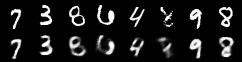

====> Test set loss: 87.3307
Sample of generated images


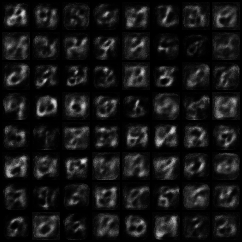



Train Epoch: 2 [0/60000 (0%)]	Loss: 92.093925
Train Epoch: 2 [12800/60000 (21%)]	Loss: 82.807716
Train Epoch: 2 [25600/60000 (43%)]	Loss: 80.777969
Train Epoch: 2 [38400/60000 (64%)]	Loss: 83.376755
Train Epoch: 2 [51200/60000 (85%)]	Loss: 81.406525
====> Epoch: 2 Average loss: 82.9054
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


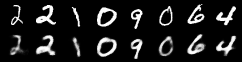

====> Test set loss: 78.1142
Sample of generated images


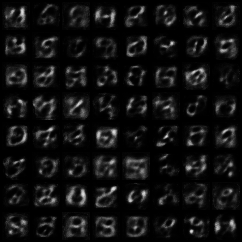



Train Epoch: 3 [0/60000 (0%)]	Loss: 81.387680
Train Epoch: 3 [12800/60000 (21%)]	Loss: 80.381615
Train Epoch: 3 [25600/60000 (43%)]	Loss: 79.533447
Train Epoch: 3 [38400/60000 (64%)]	Loss: 75.278679
Train Epoch: 3 [51200/60000 (85%)]	Loss: 77.316658
====> Epoch: 3 Average loss: 76.9993
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


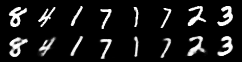

====> Test set loss: 74.5939
Sample of generated images


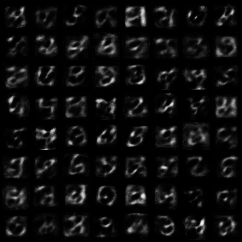



Train Epoch: 4 [0/60000 (0%)]	Loss: 75.056694
Train Epoch: 4 [12800/60000 (21%)]	Loss: 71.404266
Train Epoch: 4 [25600/60000 (43%)]	Loss: 72.664177
Train Epoch: 4 [38400/60000 (64%)]	Loss: 75.321655
Train Epoch: 4 [51200/60000 (85%)]	Loss: 74.323128
====> Epoch: 4 Average loss: 74.2301
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


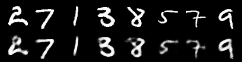

====> Test set loss: 72.5324
Sample of generated images


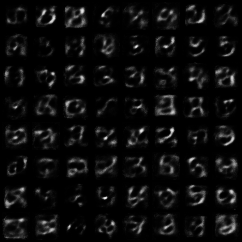



Train Epoch: 5 [0/60000 (0%)]	Loss: 72.477089
Train Epoch: 5 [12800/60000 (21%)]	Loss: 73.706619
Train Epoch: 5 [25600/60000 (43%)]	Loss: 72.391891
Train Epoch: 5 [38400/60000 (64%)]	Loss: 72.311203
Train Epoch: 5 [51200/60000 (85%)]	Loss: 71.048248
====> Epoch: 5 Average loss: 72.4003
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


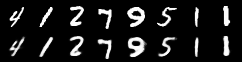

====> Test set loss: 71.2107
Sample of generated images


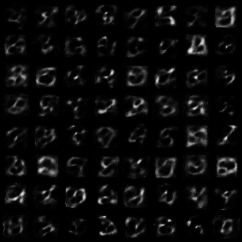



Train Epoch: 6 [0/60000 (0%)]	Loss: 72.288162
Train Epoch: 6 [12800/60000 (21%)]	Loss: 73.421318
Train Epoch: 6 [25600/60000 (43%)]	Loss: 72.975739
Train Epoch: 6 [38400/60000 (64%)]	Loss: 70.576782
Train Epoch: 6 [51200/60000 (85%)]	Loss: 72.432701
====> Epoch: 6 Average loss: 71.1110
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


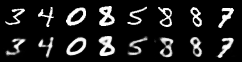

====> Test set loss: 70.1420
Sample of generated images


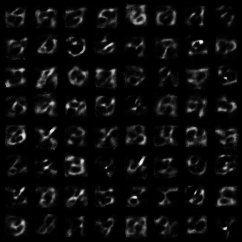



Train Epoch: 7 [0/60000 (0%)]	Loss: 71.867401
Train Epoch: 7 [12800/60000 (21%)]	Loss: 74.732254
Train Epoch: 7 [25600/60000 (43%)]	Loss: 71.172783
Train Epoch: 7 [38400/60000 (64%)]	Loss: 70.037292
Train Epoch: 7 [51200/60000 (85%)]	Loss: 66.173973
====> Epoch: 7 Average loss: 70.1013
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


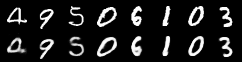

====> Test set loss: 69.3567
Sample of generated images


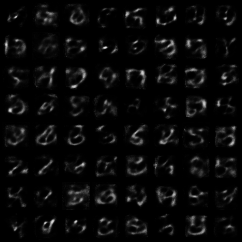



Train Epoch: 8 [0/60000 (0%)]	Loss: 69.141342
Train Epoch: 8 [12800/60000 (21%)]	Loss: 70.764366
Train Epoch: 8 [25600/60000 (43%)]	Loss: 66.888031
Train Epoch: 8 [38400/60000 (64%)]	Loss: 70.507751
Train Epoch: 8 [51200/60000 (85%)]	Loss: 67.801125
====> Epoch: 8 Average loss: 69.2997
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


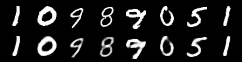

====> Test set loss: 68.8372
Sample of generated images


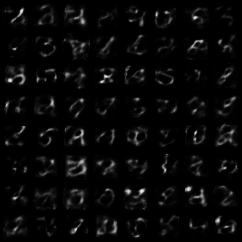



Train Epoch: 9 [0/60000 (0%)]	Loss: 65.804222
Train Epoch: 9 [12800/60000 (21%)]	Loss: 66.666359
Train Epoch: 9 [25600/60000 (43%)]	Loss: 70.051468
Train Epoch: 9 [38400/60000 (64%)]	Loss: 72.244362
Train Epoch: 9 [51200/60000 (85%)]	Loss: 69.411560
====> Epoch: 9 Average loss: 68.6689
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


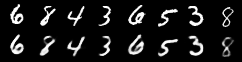

====> Test set loss: 68.1947
Sample of generated images


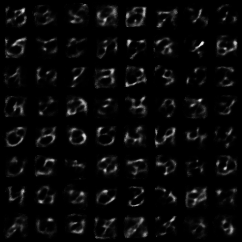



Train Epoch: 10 [0/60000 (0%)]	Loss: 68.432953
Train Epoch: 10 [12800/60000 (21%)]	Loss: 66.558212
Train Epoch: 10 [25600/60000 (43%)]	Loss: 67.229073
Train Epoch: 10 [38400/60000 (64%)]	Loss: 68.214989
Train Epoch: 10 [51200/60000 (85%)]	Loss: 68.613487
====> Epoch: 10 Average loss: 68.1443
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


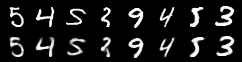

====> Test set loss: 67.7943
Sample of generated images


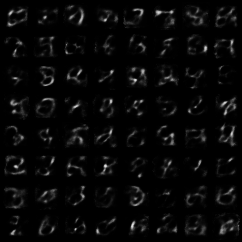

In [6]:
# train and test DAE
epochs = 10
dae_average_train_BCE = []
dae_average_test_BCE = []
dae_model = DAE().to(device)
dae_optimizer = optim.Adam(dae_model.parameters(), lr=1e-3)
for epoch in range(1, epochs + 1):
    average_train_BCE = dae_train(epoch, dae_model, dae_optimizer)
    dae_average_train_BCE.append(average_train_BCE)
    average_test_BCE = dae_test(epoch, dae_model)
    dae_average_test_BCE.append(average_test_BCE)
    with torch.no_grad():
        sample = torch.randn(64, 20).to(device)
        sample = dae_model.decode(sample).cpu()
        save_image(sample.view(64, 1, 28, 28),
                   'results/sample_' + str(epoch) + '.png')
        print('Sample of generated images')
        display(Image('results/sample_' + str(epoch) + '.png'))
        print('\n')


Train Epoch: 1 [0/60000 (0%)]	Loss_BCE: 549.537231
Train Epoch: 1 [0/60000 (0%)]	Loss_total: 549.643066
Train Epoch: 1 [12800/60000 (21%)]	Loss_BCE: 173.127792
Train Epoch: 1 [12800/60000 (21%)]	Loss_total: 183.813919
Train Epoch: 1 [25600/60000 (43%)]	Loss_BCE: 140.747116
Train Epoch: 1 [25600/60000 (43%)]	Loss_total: 154.612289
Train Epoch: 1 [38400/60000 (64%)]	Loss_BCE: 122.728432
Train Epoch: 1 [38400/60000 (64%)]	Loss_total: 140.552444
Train Epoch: 1 [51200/60000 (85%)]	Loss_BCE: 114.803253
Train Epoch: 1 [51200/60000 (85%)]	Loss_total: 132.842896
====> Epoch: 1 Average BCE loss: 150.9503
====> Epoch: 1 Average total loss: 165.7468
Sample of reconstructed images2 (top row are targets and bottom row are reconstructions)


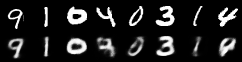

====> Test set BCE loss_VAE: 108.7890
====> Test set total loss_VAE: 129.1739
Sample of generated images


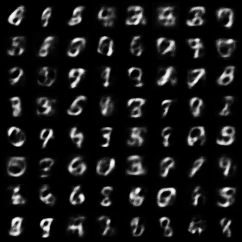



Train Epoch: 2 [0/60000 (0%)]	Loss_BCE: 110.539398
Train Epoch: 2 [0/60000 (0%)]	Loss_total: 130.888199
Train Epoch: 2 [12800/60000 (21%)]	Loss_BCE: 102.063377
Train Epoch: 2 [12800/60000 (21%)]	Loss_total: 123.478867
Train Epoch: 2 [25600/60000 (43%)]	Loss_BCE: 101.002388
Train Epoch: 2 [25600/60000 (43%)]	Loss_total: 123.112503
Train Epoch: 2 [38400/60000 (64%)]	Loss_BCE: 96.558159
Train Epoch: 2 [38400/60000 (64%)]	Loss_total: 118.675232
Train Epoch: 2 [51200/60000 (85%)]	Loss_BCE: 94.100105
Train Epoch: 2 [51200/60000 (85%)]	Loss_total: 117.573174
====> Epoch: 2 Average BCE loss: 100.0476
====> Epoch: 2 Average total loss: 121.9890
Sample of reconstructed images2 (top row are targets and bottom row are reconstructions)


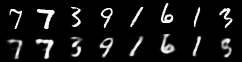

====> Test set BCE loss_VAE: 92.6576
====> Test set total loss_VAE: 115.9034
Sample of generated images


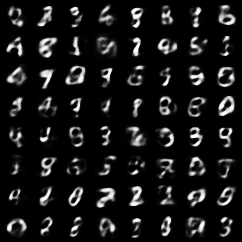



Train Epoch: 3 [0/60000 (0%)]	Loss_BCE: 93.226212
Train Epoch: 3 [0/60000 (0%)]	Loss_total: 116.306618
Train Epoch: 3 [12800/60000 (21%)]	Loss_BCE: 95.916649
Train Epoch: 3 [12800/60000 (21%)]	Loss_total: 120.600471
Train Epoch: 3 [25600/60000 (43%)]	Loss_BCE: 88.534668
Train Epoch: 3 [25600/60000 (43%)]	Loss_total: 112.134895
Train Epoch: 3 [38400/60000 (64%)]	Loss_BCE: 94.971375
Train Epoch: 3 [38400/60000 (64%)]	Loss_total: 118.909348
Train Epoch: 3 [51200/60000 (85%)]	Loss_BCE: 91.993698
Train Epoch: 3 [51200/60000 (85%)]	Loss_total: 116.686523
====> Epoch: 3 Average BCE loss: 91.0525
====> Epoch: 3 Average total loss: 114.7579
Sample of reconstructed images2 (top row are targets and bottom row are reconstructions)


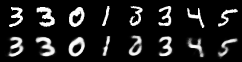

====> Test set BCE loss_VAE: 87.6377
====> Test set total loss_VAE: 112.2048
Sample of generated images


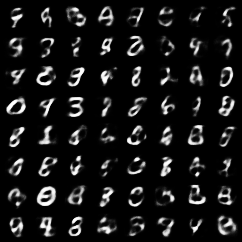



Train Epoch: 4 [0/60000 (0%)]	Loss_BCE: 90.148331
Train Epoch: 4 [0/60000 (0%)]	Loss_total: 115.265976
Train Epoch: 4 [12800/60000 (21%)]	Loss_BCE: 87.935196
Train Epoch: 4 [12800/60000 (21%)]	Loss_total: 111.505905
Train Epoch: 4 [25600/60000 (43%)]	Loss_BCE: 86.656601
Train Epoch: 4 [25600/60000 (43%)]	Loss_total: 111.236969
Train Epoch: 4 [38400/60000 (64%)]	Loss_BCE: 88.113411
Train Epoch: 4 [38400/60000 (64%)]	Loss_total: 112.687935
Train Epoch: 4 [51200/60000 (85%)]	Loss_BCE: 86.215996
Train Epoch: 4 [51200/60000 (85%)]	Loss_total: 110.788177
====> Epoch: 4 Average BCE loss: 87.4373
====> Epoch: 4 Average total loss: 111.7234
Sample of reconstructed images2 (top row are targets and bottom row are reconstructions)


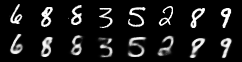

====> Test set BCE loss_VAE: 85.3903
====> Test set total loss_VAE: 110.2055
Sample of generated images


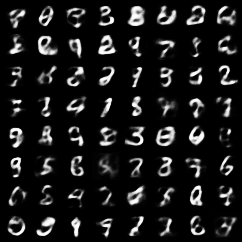



Train Epoch: 5 [0/60000 (0%)]	Loss_BCE: 86.487206
Train Epoch: 5 [0/60000 (0%)]	Loss_total: 111.491982
Train Epoch: 5 [12800/60000 (21%)]	Loss_BCE: 85.277901
Train Epoch: 5 [12800/60000 (21%)]	Loss_total: 110.163269
Train Epoch: 5 [25600/60000 (43%)]	Loss_BCE: 86.913773
Train Epoch: 5 [25600/60000 (43%)]	Loss_total: 112.963821
Train Epoch: 5 [38400/60000 (64%)]	Loss_BCE: 81.484360
Train Epoch: 5 [38400/60000 (64%)]	Loss_total: 106.493599
Train Epoch: 5 [51200/60000 (85%)]	Loss_BCE: 88.771378
Train Epoch: 5 [51200/60000 (85%)]	Loss_total: 113.297943
====> Epoch: 5 Average BCE loss: 85.3266
====> Epoch: 5 Average total loss: 109.9393
Sample of reconstructed images2 (top row are targets and bottom row are reconstructions)


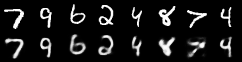

====> Test set BCE loss_VAE: 83.7550
====> Test set total loss_VAE: 108.5984
Sample of generated images


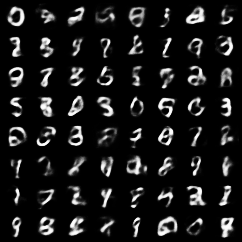



Train Epoch: 6 [0/60000 (0%)]	Loss_BCE: 84.186928
Train Epoch: 6 [0/60000 (0%)]	Loss_total: 108.794029
Train Epoch: 6 [12800/60000 (21%)]	Loss_BCE: 85.562935
Train Epoch: 6 [12800/60000 (21%)]	Loss_total: 110.994171
Train Epoch: 6 [25600/60000 (43%)]	Loss_BCE: 82.141716
Train Epoch: 6 [25600/60000 (43%)]	Loss_total: 106.265099
Train Epoch: 6 [38400/60000 (64%)]	Loss_BCE: 84.459663
Train Epoch: 6 [38400/60000 (64%)]	Loss_total: 108.720650
Train Epoch: 6 [51200/60000 (85%)]	Loss_BCE: 81.599007
Train Epoch: 6 [51200/60000 (85%)]	Loss_total: 106.064659
====> Epoch: 6 Average BCE loss: 83.9804
====> Epoch: 6 Average total loss: 108.7746
Sample of reconstructed images2 (top row are targets and bottom row are reconstructions)


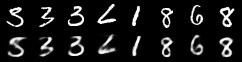

====> Test set BCE loss_VAE: 82.6810
====> Test set total loss_VAE: 107.6713
Sample of generated images


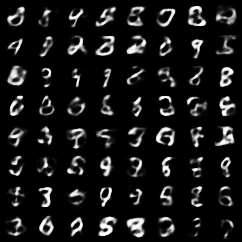



Train Epoch: 7 [0/60000 (0%)]	Loss_BCE: 85.703621
Train Epoch: 7 [0/60000 (0%)]	Loss_total: 110.866440
Train Epoch: 7 [12800/60000 (21%)]	Loss_BCE: 84.672646
Train Epoch: 7 [12800/60000 (21%)]	Loss_total: 109.756744
Train Epoch: 7 [25600/60000 (43%)]	Loss_BCE: 83.441620
Train Epoch: 7 [25600/60000 (43%)]	Loss_total: 108.222809
Train Epoch: 7 [38400/60000 (64%)]	Loss_BCE: 84.197586
Train Epoch: 7 [38400/60000 (64%)]	Loss_total: 109.277283
Train Epoch: 7 [51200/60000 (85%)]	Loss_BCE: 86.811455
Train Epoch: 7 [51200/60000 (85%)]	Loss_total: 111.836639
====> Epoch: 7 Average BCE loss: 83.0081
====> Epoch: 7 Average total loss: 107.9273
Sample of reconstructed images2 (top row are targets and bottom row are reconstructions)


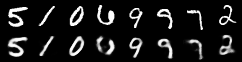

====> Test set BCE loss_VAE: 82.1572
====> Test set total loss_VAE: 106.9566
Sample of generated images


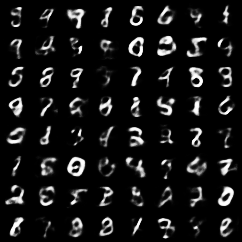



Train Epoch: 8 [0/60000 (0%)]	Loss_BCE: 79.563576
Train Epoch: 8 [0/60000 (0%)]	Loss_total: 103.586700
Train Epoch: 8 [12800/60000 (21%)]	Loss_BCE: 81.779060
Train Epoch: 8 [12800/60000 (21%)]	Loss_total: 107.236908
Train Epoch: 8 [25600/60000 (43%)]	Loss_BCE: 81.160759
Train Epoch: 8 [25600/60000 (43%)]	Loss_total: 105.701813
Train Epoch: 8 [38400/60000 (64%)]	Loss_BCE: 79.575760
Train Epoch: 8 [38400/60000 (64%)]	Loss_total: 104.985367
Train Epoch: 8 [51200/60000 (85%)]	Loss_BCE: 85.690918
Train Epoch: 8 [51200/60000 (85%)]	Loss_total: 111.574074
====> Epoch: 8 Average BCE loss: 82.2498
====> Epoch: 8 Average total loss: 107.2737
Sample of reconstructed images2 (top row are targets and bottom row are reconstructions)


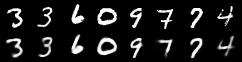

====> Test set BCE loss_VAE: 81.3101
====> Test set total loss_VAE: 106.4138
Sample of generated images


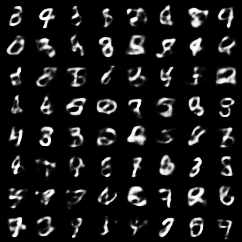



Train Epoch: 9 [0/60000 (0%)]	Loss_BCE: 83.505623
Train Epoch: 9 [0/60000 (0%)]	Loss_total: 108.640450
Train Epoch: 9 [12800/60000 (21%)]	Loss_BCE: 76.632996
Train Epoch: 9 [12800/60000 (21%)]	Loss_total: 101.304398
Train Epoch: 9 [25600/60000 (43%)]	Loss_BCE: 83.548599
Train Epoch: 9 [25600/60000 (43%)]	Loss_total: 108.964790
Train Epoch: 9 [38400/60000 (64%)]	Loss_BCE: 82.777229
Train Epoch: 9 [38400/60000 (64%)]	Loss_total: 108.292999
Train Epoch: 9 [51200/60000 (85%)]	Loss_BCE: 76.166046
Train Epoch: 9 [51200/60000 (85%)]	Loss_total: 100.584930
====> Epoch: 9 Average BCE loss: 81.6171
====> Epoch: 9 Average total loss: 106.7206
Sample of reconstructed images2 (top row are targets and bottom row are reconstructions)


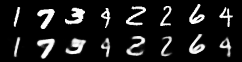

====> Test set BCE loss_VAE: 80.9971
====> Test set total loss_VAE: 106.2389
Sample of generated images


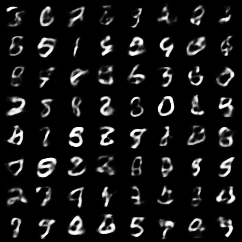



Train Epoch: 10 [0/60000 (0%)]	Loss_BCE: 80.660065
Train Epoch: 10 [0/60000 (0%)]	Loss_total: 106.282349
Train Epoch: 10 [12800/60000 (21%)]	Loss_BCE: 81.811623
Train Epoch: 10 [12800/60000 (21%)]	Loss_total: 106.585381
Train Epoch: 10 [25600/60000 (43%)]	Loss_BCE: 79.587700
Train Epoch: 10 [25600/60000 (43%)]	Loss_total: 104.757248
Train Epoch: 10 [38400/60000 (64%)]	Loss_BCE: 82.028954
Train Epoch: 10 [38400/60000 (64%)]	Loss_total: 107.483757
Train Epoch: 10 [51200/60000 (85%)]	Loss_BCE: 79.738808
Train Epoch: 10 [51200/60000 (85%)]	Loss_total: 105.011818
====> Epoch: 10 Average BCE loss: 81.1444
====> Epoch: 10 Average total loss: 106.3234
Sample of reconstructed images2 (top row are targets and bottom row are reconstructions)


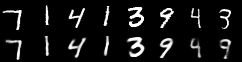

====> Test set BCE loss_VAE: 80.3822
====> Test set total loss_VAE: 105.6122
Sample of generated images


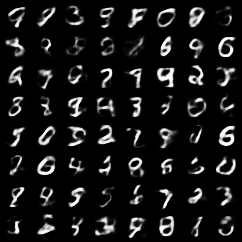

In [7]:

# train and test VAE
epochs = 10
vae_average_train_losses = []
vae_average_train_BCE = []
vae_average_test_losses = []
vae_average_test_BCE = []
vae_model = VAE().to(device)
vae_optimizer = optim.Adam(vae_model.parameters(), lr=1e-3)
for epoch in range(1, epochs + 1):
    average_train_loss, average_train_BCE = vae_train(epoch, vae_model, vae_optimizer)
    vae_average_train_losses.append(average_train_loss)
    vae_average_train_BCE.append(average_train_BCE)
    average_test_loss, average_test_BCE = vae_test(epoch, vae_model)
    vae_average_test_losses.append(average_test_loss)
    vae_average_test_BCE.append(average_test_BCE)
    with torch.no_grad():
        sample = torch.randn(64, 20).to(device)
        sample = vae_model.decode(sample).cpu()
        save_image(sample.view(64, 1, 28, 28),
                   'results/sample_' + str(epoch) + '.png')
        print('Sample of generated images')
        display(Image('results/sample_' + str(epoch) + '.png'))
        print('\n')


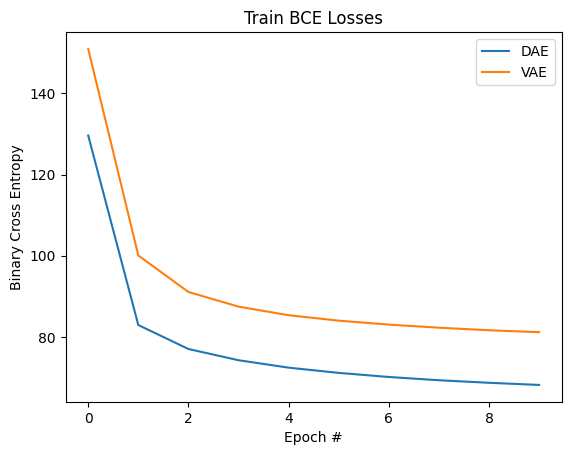

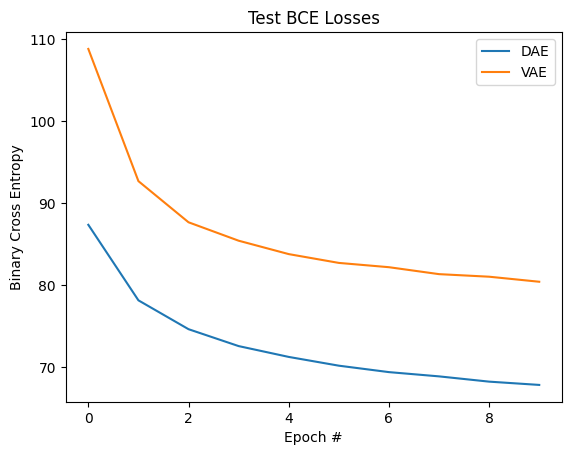

In [8]:

# Plot Train BCE Losses
plt.plot(dae_average_train_BCE)
plt.plot(vae_average_train_BCE)
plt.title('Train BCE Losses')
plt.ylabel('Binary Cross Entropy')
plt.xlabel('Epoch #')
plt.legend(['DAE','VAE'], loc='upper right')
plt.show()

# Plot Test BCE Losses
plt.plot(dae_average_test_BCE)
plt.plot(vae_average_test_BCE)
plt.title('Test BCE Losses')
plt.ylabel('Binary Cross Entropy')
plt.xlabel('Epoch #')
plt.legend(['DAE','VAE'], loc='upper right')
plt.show()

## Explanation


The DAE tries to reconstruct the digits by passing the image(input) through the encoder(f) compressing them and through a decoder(g). During training, the BCE loss, which is a function of W(f) and W(g), tries to update weights as such that the reconstructed images are almost the same as the actual images(minimizing the reconstruction error), with little loss in the information (g(f(x))=x, and the quality of the reconstructed images are good). However, It has little luck generating samples from the normal distribution. That's because the distribution of the images are far from the normal distribution, and the decoder hasn't learn to generate images from the normal distribution, and just from the distribution of the images in the training set.


To solve this issue, VAE models are introduced, where we try to teach the model to reconstruct images, generate images from the normal distribution as we try to make the train images get closer to the normal distribution, so it has a mean of 0 and variance of 1 (in the reparameterizing function). 
The BCE loss for VAE is more than DAE. The VAE model is trying to minimize the total loss(BCE+KL divergence), so it has two objectives: update W(f) and and W(g) in a way that the model is able to reconstruct train images, but also adjust W(f) in a way that the distance between the train encoder distribution approaches the normal distribution. 
There's a tradeoff between these two objectives, so we can see that VAE reconstructs images with a slightly less quality, but is able to generate some acceptable digits from the normal noise. Yet, the quality of generated images should improve.


In conclusion, the BCE test loss and train loss for VAE are higher because the quality of reconstructed images are a bit lower than for the DAE, and that's because VAE is trying to. adjust W(f) so that it can generate better fake images from the noise.